In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import numpy as np
import pylab as plt
%matplotlib inline
from scipy import signal,fftpack
from scipy.fftpack import fft, ifft

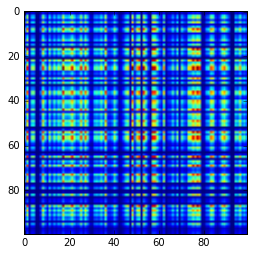

In [3]:
a = np.random.random(100)
b = np.random.random(100)
c = np.outer(a, b)
plt.imshow(c)

In [4]:
c[::5,::5][:16, :16].shape

(16, 16)

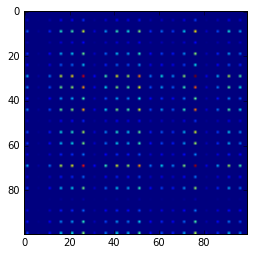

In [5]:
d = np.zeros((100,100))
d[4::5,1::5] = c[::5,::5]
plt.imshow(d)

In [6]:
fa = ifft(np.conjugate(fft(c))*fft(d))
np.where(fa==fa.max())

(array([69]), array([68]))

In [7]:
z = signal.correlate2d(c,d)

In [8]:
np.unique(z)[-5:]

array([ 26.00091584,  26.47935075,  26.69073388,  26.93638069,  27.4320288 ])

In [9]:
x, y = np.where(z==z.max())
x-(100-1), y-(100-1),z[x,y]

(array([-4]), array([7]), array([ 27.4320288]))

In [10]:
x, y = np.where(z>np.unique(z)[-5])
x-(100-1), y-(100-1),z[x,y]

(array([-12,  -4,  -4,  -4]),
 array([ 7, -1,  0,  7]),
 array([ 26.47935075,  26.93638069,  26.69073388,  27.4320288 ]))

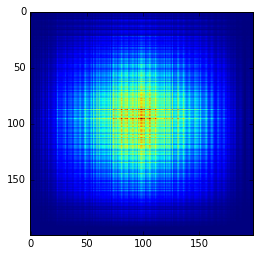

In [11]:
plt.imshow(z)

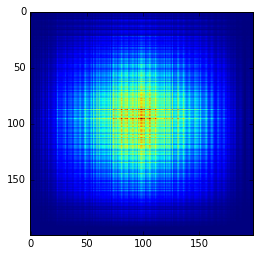

In [12]:
plt.imshow(signal.fftconvolve(c, d[::-1, ::-1]))

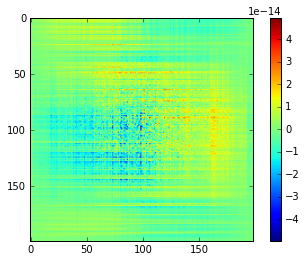

In [13]:
plt.imshow(signal.fftconvolve(c, d[::-1, ::-1])-z)
plt.colorbar()

In [63]:
from bisect import bisect_left
import numpy as np
def next_fast_len(target):
    """
    Find the next fast size of input data to `fft`, for zero-padding, etc.
    SciPy's FFTPACK has efficient functions for radix {2, 3, 4, 5}, so this
    returns the next composite of the prime factors 2, 3, and 5 which is
    greater than or equal to `target`. (These are also known as 5-smooth
    numbers, regular numbers, or Hamming numbers.)
    Parameters
    ----------
    target : int
        Length to start searching from.  Must be a positive integer.
    Returns
    -------
    out : int
        The first 5-smooth number greater than or equal to `target`.
    Notes
    -----
    .. versionadded:: 0.18.0
    Examples
    --------
    On a particular machine, an FFT of prime length takes 133 ms:
    >>> from scipy import fftpack
    >>> min_len = 10007  # prime length is worst case for speed
    >>> a = np.random.randn(min_len)
    >>> b = fftpack.fft(a)
    Zero-padding to the next 5-smooth length reduces computation time to
    211 us, a speedup of 630 times:
    >>> fftpack.helper.next_fast_len(min_len)
    10125
    >>> b = fftpack.fft(a, 10125)
    Rounding up to the next power of 2 is not optimal, taking 367 us to
    compute, 1.7 times as long as the 5-smooth size:
    >>> b = fftpack.fft(a, 16384)
    """
    hams = (8, 9, 10, 12, 15, 16, 18, 20, 24, 25, 27, 30, 32, 36, 40, 45, 48,
            50, 54, 60, 64, 72, 75, 80, 81, 90, 96, 100, 108, 120, 125, 128,
            135, 144, 150, 160, 162, 180, 192, 200, 216, 225, 240, 243, 250,
            256, 270, 288, 300, 320, 324, 360, 375, 384, 400, 405, 432, 450,
            480, 486, 500, 512, 540, 576, 600, 625, 640, 648, 675, 720, 729,
            750, 768, 800, 810, 864, 900, 960, 972, 1000, 1024, 1080, 1125,
            1152, 1200, 1215, 1250, 1280, 1296, 1350, 1440, 1458, 1500, 1536,
            1600, 1620, 1728, 1800, 1875, 1920, 1944, 2000, 2025, 2048, 2160,
            2187, 2250, 2304, 2400, 2430, 2500, 2560, 2592, 2700, 2880, 2916,
            3000, 3072, 3125, 3200, 3240, 3375, 3456, 3600, 3645, 3750, 3840,
            3888, 4000, 4050, 4096, 4320, 4374, 4500, 4608, 4800, 4860, 5000,
            5120, 5184, 5400, 5625, 5760, 5832, 6000, 6075, 6144, 6250, 6400,
            6480, 6561, 6750, 6912, 7200, 7290, 7500, 7680, 7776, 8000, 8100,
            8192, 8640, 8748, 9000, 9216, 9375, 9600, 9720, 10000)

    if target <= 6:
        return target

    # Quickly check if it's already a power of 2
    if not (target & (target-1)):
        return target

    # Get result quickly for small sizes, since FFT itself is similarly fast.
    if target <= hams[-1]:
        return hams[bisect_left(hams, target)]

    match = float('inf')  # Anything found will be smaller
    p5 = 1
    while p5 < target:
        p35 = p5
        while p35 < target:
            # Ceiling integer division, avoiding conversion to float
            # (quotient = ceil(target / p35))
            quotient = -(-target // p35)

            # Quickly find next power of 2 >= quotient
            p2 = 2**((quotient - 1).bit_length())

            N = p2 * p35
            if N == target:
                return N
            elif N < match:
                match = N
            p35 *= 3
            if p35 == target:
                return p35
        if p35 < match:
            match = p35
        p5 *= 5
        if p5 == target:
            return p5
    if p5 < match:
        match = p5
    return match

def _centered(arr, newshape):
    # Return the center newshape portion of the array.
    newshape = np.asarray(newshape)
    currshape = np.array(arr.shape)
    startind = (currshape - newshape) // 2
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

def fft_correlation(in1, in2, norm=True):
    s1, s2 = np.array(in1.shape), np.array(in2.shape)
    shape = s1 + s2 - 1
    fshape = [next_fast_len(int(i)) for i in shape]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    
    sp1 = np.fft.rfftn(in1[::-1,::-1], fshape)
    sp2 = np.fft.rfftn(in2, fshape)
    if norm:
        ret = (np.fft.irfftn(sp1* sp2/np.abs(sp1* sp2), fshape)[fslice])
    else:
        ret = (np.fft.irfftn(sp1* sp2, fshape)[fslice].copy())
    cr = _centered(ret, s1) # cross correlation
    
    return cr

In [52]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus   
G = gaussian(40,40,2,2,0,1)

[[4]
 [1]]


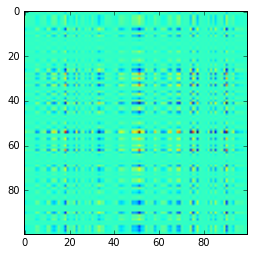

In [65]:
ret = fft_correlation(c,d)
print np.array(np.where(ret==ret.max()))-50
plt.imshow(ret)

In [19]:
import gdal
import glob 
import gdal
import numpy as np
import numpy.ma as ma
import sys
sys.path.insert(0, 'python')
import kernels
from geo_trans import *
from readSent import *
import pylab as plt
%matplotlib inline
from get_brdf import * 
from linear_plot7 import *
from scipy.interpolate import griddata
from LS_optimizing import *
from Dload_Finder import *

In [20]:
lat, lon, year = 37.474469, 117.346456, 2016
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']

Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))

In [21]:
doys = [int(i.split('2016')[1][:3]) for i in Hfiles]
doy = doys[1]; Hsat = 'L'

Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(path, row, year, doy)
Lfile = glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,doy,h,v))[0]
Hfile, Lfile

('/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016070LGN00_sr_',
 'm_data/MCD43A1.A2016070.h27v05.006.2016179142315.hdf')

In [22]:
with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
    for line in inF:
        if 'CLOUD_COVER ' in line:
            cloud_cover =  float(line.split('= ')[1])
if cloud_cover<20:
    print 'Less than 20% cloud.'
    b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
    corners = b1.shape

    cloud = gdal.Open(Hfile[:-4]+'_cfmask.tif').ReadAsArray()
    cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0

    dic = {}

    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif 'ROLL_ANGLE' in line:
                vza = float(line.split(' = ')[1])
            elif 'SUN_AZIMUTH' in line:
                saa = float(line.split(' = ')[1])
            elif 'SUN_ELEVATION' in line:
                sza = float(line.split(' = ')[1])
    with open('Landsat_azm.pkl', 'r') as savefile:
        Landsat_azm = pkl.load(savefile)

    lazm = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
    raa = lazm-saa

    L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)

    tems = np.zeros((3,6))
    tems[0,:] = sza
    tems[1,:] = vza
    tems[2,:] = raa

    brdfs, rws = get_brdf_six(Lfile, (tems[0], tems[1], tems[2]), bands=[3,4,1,2,6,7])
    #brdfs.mask = brdfs.mask|(rws<1)
    args = Hfile, cloud, brdfs, H_inds, L_inds

Less than 20% cloud.


In [23]:
Lx, Ly = L_inds
Hx, Hy = H_inds
L_inds, H_inds

((array([354, 354, 354, ..., 864, 864, 864]),
  array([ 188,  189,  190, ..., 1316, 1317, 1318])),
 array([[  10,   10,   10, ..., 7842, 7842, 7842],
        [   1,   17,   32, ..., 7655, 7671, 7686]]))

In [24]:
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)

7


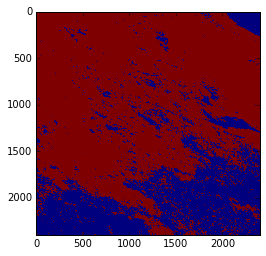

In [25]:
ind=5
B_num = L_bands[ind]
print B_num
H_data = gdal.Open(Hfile+'band%d.tif'%B_num).ReadAsArray()*0.0001
mask = ~(H_data<0).astype('bool')
small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
val_mask = (~dia_cloud)&small_mask
L_data = brdfs[ind]
qa_masks = rws<2
qa_mask = qa_masks[ind]
plt.imshow(qa_masks[0])

In [26]:
avker = np.ones((40,40))
navker = avker/avker.sum()
s = signal.fftconvolve(H_data, navker, mode='same')

In [27]:
Lvals = L_data[Lx.astype(int), Ly.astype(int)]*0.001
Larray = np.zeros_like(H_data)
Larray[Hx.astype(int), Hy.astype(int)] = Lvals

In [28]:
Hx, Hy

(array([  10,   10,   10, ..., 7842, 7842, 7842]),
 array([   1,   17,   32, ..., 7655, 7671, 7686]))

In [68]:
%time ret = fft_correlation(s,Larray)

CPU times: user 29.4 s, sys: 11.9 s, total: 41.3 s
Wall time: 41.4 s


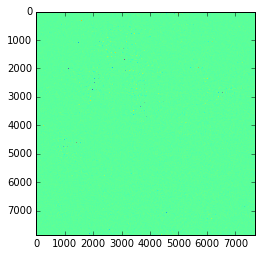

In [69]:
plt.imshow(ret)

In [70]:
x0,y0 = np.array(ret.shape)/2

In [71]:
x0,y0

(3925, 3845)

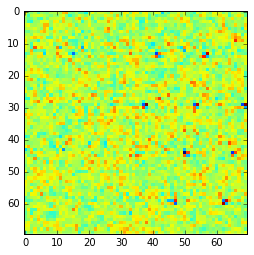

In [72]:
ccr = ret[x0-35:x0+35,y0-35:y0+35]
plt.imshow(ccr, interpolation='None')

In [61]:
np.array(np.where(ccr>np.unique(ccr)[-5]))-40

array([[-34, -34, -20, -18],
       [-38, -37, -39, -40]])

In [62]:
np.array(np.where(ccr==ccr.max()))-40

array([[-34],
       [-37]])

In [36]:
np.unique(ccr)[-5:]

array([ 0.00032296,  0.00034804,  0.00034923,  0.00036225,  0.00038949])